# Ring World Data Analysis.

Finding what parameters to run for the final experiments.

In [51]:
using Plots; gr()
using Reproduce
using FileIO
using JLD2
using Statistics
using ProgressMeter
data_home = "../working_results/sweeps"

"../working_results/sweeps"

In [32]:
function get_setting(ic, clean_func)

    diff_dict = diff(ic)
    
    itms = ic.items
    res = zeros(length(ic.items))
    for (itm_idx, itm) ∈ enumerate(itms)
        try
            res[itm_idx] = clean_func(
                load(joinpath(itm.folder_str, "results.jld2")))
            if isnan(res[itm_idx])
                res[itm_idx] = Inf
            end
        catch
            println("error")
            res[itm_idx] = Inf
        end
    end
    μ = mean(res)
    if isinf(μ)
        μ = 10000
    end
    σ = std(res)./sqrt(length(itms))
    if isnan(σ)
        σ = 0
    end
#     println(μ, " ", σ)
#     println(length(itms))
    
    return μ, σ
end

function get_best_setting(ic, sweep_param, clean_func)

    diff_dict = diff(ic)

    μ = zeros(length(diff_dict[sweep_param]))
    σ = zeros(length(diff_dict[sweep_param]))
    
    for (swprm_idx, swprm) ∈ enumerate(diff_dict[sweep_param])
        sub_ic = search(ic, Dict(sweep_param=>swprm))
        res = zeros(length(sub_ic.items))
        for (itm_idx, itm) ∈ enumerate(sub_ic.items)
            try
                res[itm_idx] = clean_func(
                    FileIO.load(joinpath(itm.folder_str, "results.jld2")))
                if isnan(res[itm_idx])
                    res[itm_idx] = Inf
                end
            catch
                println("error")
                res[itm_idx] = Inf
            end
        end
        μ[swprm_idx] = mean(res)
        σ[swprm_idx] = std(res)./sqrt(length(sub_ic.items))
    end
    min_idx = findmin(μ)
    diff_dict[sweep_param][min_idx[2]], (min_idx[1], σ[min_idx[2]])
end


"""
    get_lines_sensitivity(folder_loc, sens_param, line_params, get_best_func)

Get sensitivity curves over sens_parameters using get_best_Func and line_params. 
# Arguments
-`get_best_func`: A function which takes an itemcollection and returns the best setting. Usually this will be a closure.
- `line_params`: The parameters defining each new line.
- `sens_param`: The x-axis parametere
"""
function get_lines_sensitivity(item_col, sens_param, line_params, get_best_func; clean_func=nothing)

    diff_dict = diff(item_col)
    res_dict = Dict()

    @showprogress 0.1 "Line: " for line_prm ∈ Iterators.product((diff_dict[k] for k ∈ line_params)...)
        sd = Dict(line_params[i]=>line_prm[i] for i ∈ 1:length(line_params))
        _, _, _sub_itms = search(item_col, Dict(line_params[i]=>line_prm[i] for i ∈ 1:length(line_params)))
        sub_ic = ItemCollection(_sub_itms)
        sub_diff_dict = diff(sub_ic)
        μ = zeros(length(sub_diff_dict[sens_param]))
        σ = zeros(length(sub_diff_dict[sens_param]))
        for (sprm_idx, sprm) ∈ enumerate(sub_diff_dict[sens_param])
            _, _, sprm_items = search(sub_ic, Dict(sens_param=>sprm))
            _sprm_ic = ItemCollection(sprm_items)
            if get_best_func isa Nothing
#                 println("Here")
                μ[sprm_idx], σ[sprm_idx] = get_setting(_sprm_ic, clean_func)
            else
                prm, (μ[sprm_idx], σ[sprm_idx]) = get_best_func(_sprm_ic)
            end
        end
        res_dict[line_prm] = (μ, σ)
    end
    res_dict, diff_dict[sens_param]
end

get_lines_sensitivity(folder_str::AbstractString, sens_param, line_params, get_best_func) =
    get_lines_sensitivity(ItemCollection(folder_str), sens_param, line_params, get_best_func; clean_func=nothing)

function plot_sensitivity(folder_loc_or_ic, sens_param, line_params, get_best_func, settings_dict=nothing; kwargs...)
    
    res_dict, x_axis = get_lines_sensitivity(folder_loc_or_ic, sens_param, line_params, get_best_func)
    kys = collect(keys(res_dict))
    
    if settings_dict isa Nothing
        settings_dict = Dict(k=>[:label=>"$k"] for k ∈ kys)
    end
    
    plt = if settings_dict isa Nothing
        plot(x_axis, res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; kwargs...)
    else
        plot(x_axis, res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; settings_dict[kys[1]]..., kwargs...)
    end
    for k ∈ kys[2:end]
        if settings_dict isa Nothing
            plot!(plt, x_axis, res_dict[k][1], ribbon=res_dict[k][2])
        else
            plot!(plt, x_axis, res_dict[k][1], ribbon=res_dict[k][2]; settings_dict[k]...)
        end
    end
    plt
end

function get_x_axis(key, res_dicts, xaxises)
    for (rd_idx, rd) in enumerate(res_dicts)
        if key ∈ keys(rd)
            return xaxises[rd_idx]
        end
    end
end


function plot_sensitivity(res_dict::Dict, x_axis::AbstractArray, settings_dict=nothing; kwargs...)
    x_axis_d = Dict(k=>x_axis for k in keys(res_dict))
    plot_sensitivity(res_dict, x_axis_d, settings_dict; kwargs...)
end


function plot_sensitivity(res_dicts::Tuple, x_axises::Tuple, settings_dict=nothing; kwargs...)
    res_dict = merge(res_dicts...)
    x_axis_d = Dict(k=>get_x_axis(k, res_dicts, x_axises) for k in keys(res_dict))
    plot_sensitivity(res_dict, x_axis_d, settings_dict; kwargs...)
end



function plot_sensitivity(res_dict::Dict, x_axis_d::Dict, settings_dict=nothing;kwargs...)


    kys = collect(keys(res_dict))
    
    if settings_dict isa Nothing
        settings_dict = Dict(k=>[:label=>"$k"] for k ∈ kys)
    end

    plt = plot(x_axis_d[kys[1]], res_dict[kys[1]][1], ribbon=res_dict[kys[1]][2]; settings_dict[kys[1]]..., kwargs...)
    for k ∈ kys[2:end]
        plot!(plt, x_axis_d[k], res_dict[k][1], ribbon=res_dict[k][2]; settings_dict[k]...)
    end
    plt
end

plot_sensitivity (generic function with 8 methods)

# GVFN

In [4]:
ic_gvfn = ItemCollection(joinpath(data_home, "ringworld_gvfn/data"));

ic_gvfn_adam = ItemCollection(joinpath(data_home, "ringworld_gvfn_adam/data"));
diff(ic_gvfn)

Dict{String,Array} with 6 entries:
  "alpha"      => [0.00877915, 0.0131687, 0.0197531, 0.0296296, 0.0444444, 0.06…
  "horde"      => ["chain", "gamma_chain", "gammas_aj", "gammas_term"]
  "truncation" => [1, 2, 3, 4, 6, 8, 12, 16]
  "outhorde"   => ["gammas_term", "onestep"]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "size"       => [6, 10]

In [3]:
function plot_stepsize_sens(ic; res_key="all", kwargs...)
    diff(ic)

    res_dict, prm_dict = get_lines_sensitivity(ic, "alpha", ["truncation"], nothing; clean_func=(d)->d["results"][res_key]);

    typeof(ret)

    plt = nothing
    for k ∈ keys(res_dict)
        if plt == nothing
            plt = plot(prm_dict, res_dict[k][1], ribbon=res_dict[k][2], label=string(k); kwargs...)
        else
            plot!(prm_dict, res_dict[k][1], ribbon=res_dict[k][2], label=string(k))
        end
    end
    plt
end

function plot_gvfn_stepsize_sense(ic, s, outhorde, res_key)
    sub_ic = ItemCollection(search(ic, Dict("size"=>s, "outhorde"=>outhorde))[3])
    plts = []
    for horde ∈ diff(sub_ic)["horde"]
        sub_ic_2 = ItemCollection(search(sub_ic, Dict("horde"=>horde)))
        push!(plts, plot_stepsize_sens(sub_ic_2; res_key=res_key, title=horde, xlabel="alpha"))
    end
    plot(plts..., size=(800,800))
end


function plot_rnn_stepsize_sens(ic, s, outhorde, res_key; kwargs...)
    sub_ic = ItemCollection(search(ic, Dict("size"=>s, "outhorde"=>outhorde))[3])
    plts = []
    for cell ∈ diff(sub_ic)["cell"]
        sub_ic_2 = ItemCollection(search(sub_ic, Dict("cell"=>cell)))
        push!(plts, plot_stepsize_sens(sub_ic_2; res_key=res_key, title=cell, xlabel="alpha", kwargs...))
    end
    plot(plts..., size=(800,800))
end


plot_rnn_stepsize_sens (generic function with 1 method)

get_final_rnn_params (generic function with 1 method)

In [78]:
gvfn_final_params = get_final_gvfn_params(ic_gvfn, 6, "gammas_term", "end")
# @show gvfn_final_params

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Dict{String,Any} with 4 entries:
  "chain"       => Dict{String,Any}[Dict("alpha"=>0.0131687,"horde"=>"chain","t…
  "gammas_aj"   => Dict{String,Any}[Dict("alpha"=>0.0666667,"horde"=>"gammas_aj…
  "gamma_chain" => Dict{String,Any}[Dict("alpha"=>0.0131687,"horde"=>"gamma_cha…
  "gammas_term" => Dict{String,Any}[Dict("alpha"=>0.0666667,"horde"=>"gammas_te…

In [86]:
0.1*1.5^-1

0.06666666666666667

In [82]:
gvfn_final_params["gammas_aj"]

8-element Array{Dict{String,Any},1}:
 Dict("alpha" => 0.06666666666666667,"horde" => "gammas_aj","truncation" => 1)  
 Dict("alpha" => 0.019753086419753086,"horde" => "gammas_aj","truncation" => 2) 
 Dict("alpha" => 0.013168724279835392,"horde" => "gammas_aj","truncation" => 3) 
 Dict("alpha" => 0.013168724279835392,"horde" => "gammas_aj","truncation" => 4) 
 Dict("alpha" => 0.013168724279835392,"horde" => "gammas_aj","truncation" => 6) 
 Dict("alpha" => 0.013168724279835392,"horde" => "gammas_aj","truncation" => 8) 
 Dict("alpha" => 0.013168724279835392,"horde" => "gammas_aj","truncation" => 12)
 Dict("alpha" => 0.013168724279835392,"horde" => "gammas_aj","truncation" => 16)

In [62]:
gvfn_final_params["gammas_aj"]

Dict{Int64,Any} with 8 entries:
  12 => 0.0131687
  4  => 0.0131687
  2  => 0.0131687
  3  => 0.0131687
  16 => 0.0131687
  8  => 0.0131687
  6  => 0.0131687
  1  => 0.0296296

In [48]:
gvfn_final_params["chain"][1]

Dict{String,Any} with 16 entries:
  "opt"        => "Descent"
  "steps"      => 300000
  "outhorde"   => "onestep"
  "outgamma"   => 0.0
  "_GIT_INFO"  => "0"
  "activation" => "sigmoid"
  "sweep"      => true
  "alpha"      => 0.0131687
  "horde"      => "chain"
  "size"       => 6
  "save_dir"   => "/home/mkschleg/scratch/GVFN/ringworld_gvfn/data"
  "_HASH"      => 0x2ab3b0295f153434
  "truncation" => 1
  "gamma"      => 0.95
  "seed"       => 10
  "_SAVE"      => "/home/mkschleg/scratch/GVFN/ringworld_gvfn/data/RP_0_0x2ab3b…

In [31]:
gvfn_final_params = get_final_gvfn_params(ic_gvfn, 6, "gammas_term", "end")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Dict{String,Any} with 4 entries:
  "chain"       => Dict{Int64,Any}(12=>Dict{String,Any}("opt"=>"Descent","steps…
  "gammas_aj"   => Dict{Int64,Any}(12=>Dict{String,Any}("opt"=>"Descent","steps…
  "gamma_chain" => Dict{Int64,Any}(12=>Dict{String,Any}("opt"=>"Descent","steps…
  "gammas_term" => Dict{Int64,Any}(12=>Dict{String,Any}("opt"=>"Descent","steps…

In [36]:
gvfn_final_params["chain"][3]

Dict{String,Any} with 16 entries:
  "opt"        => "Descent"
  "steps"      => 300000
  "outhorde"   => "gammas_term"
  "outgamma"   => 0.0
  "_GIT_INFO"  => "0"
  "activation" => "sigmoid"
  "sweep"      => true
  "alpha"      => 0.3375
  "horde"      => "chain"
  "size"       => 6
  "save_dir"   => "/home/mkschleg/scratch/GVFN/ringworld_gvfn/data"
  "_HASH"      => 0x2347ce91c9ddc804
  "truncation" => 3
  "gamma"      => 0.95
  "seed"       => 2
  "_SAVE"      => "/home/mkschleg/scratch/GVFN/ringworld_gvfn/data/RP_0_0x2347c…

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


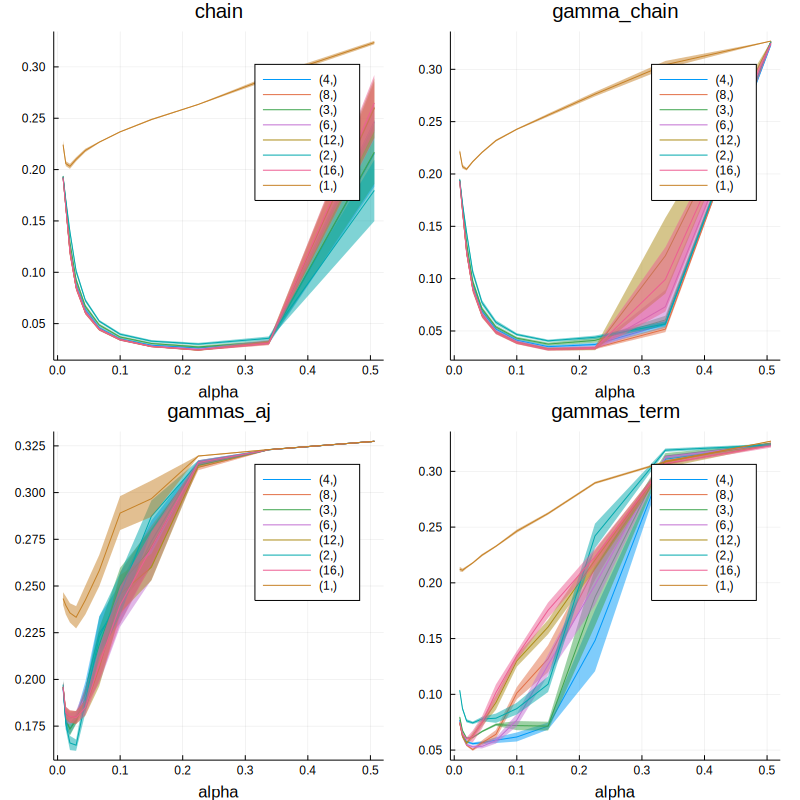

In [37]:
plot_gvfn_stepsize_sense(ic_gvfn, 6, "onestep", "all")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04


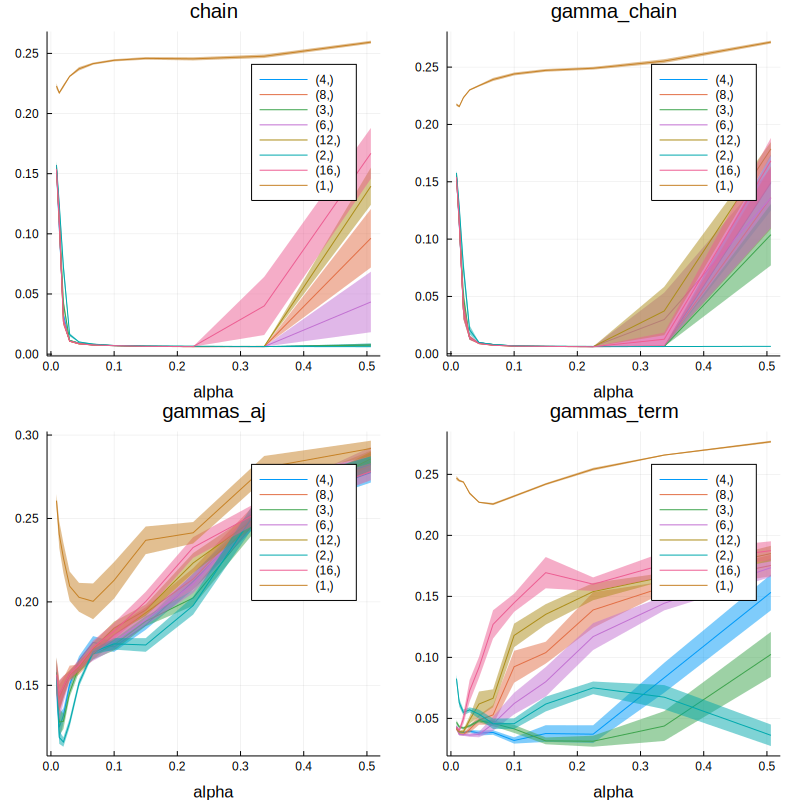

In [49]:
plot_gvfn_stepsize_sense(ic_gvfn, 6, "gammas_term", "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04


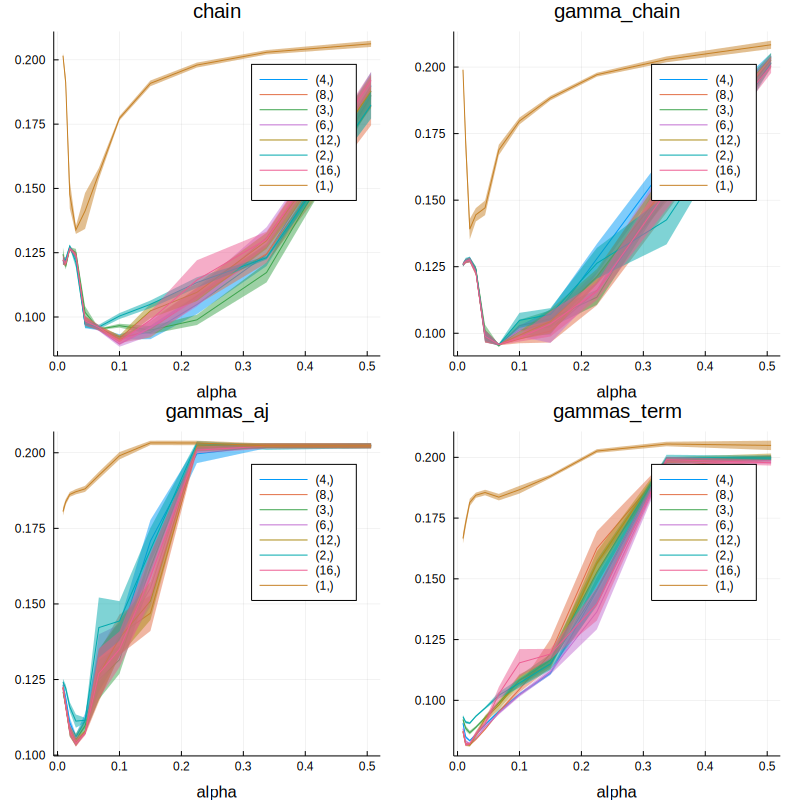

In [50]:
plot_gvfn_stepsize_sense(ic_gvfn, 10, "onestep", "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04
Line: 100%|█████████████████████████████████████████████| Time: 0:00:04


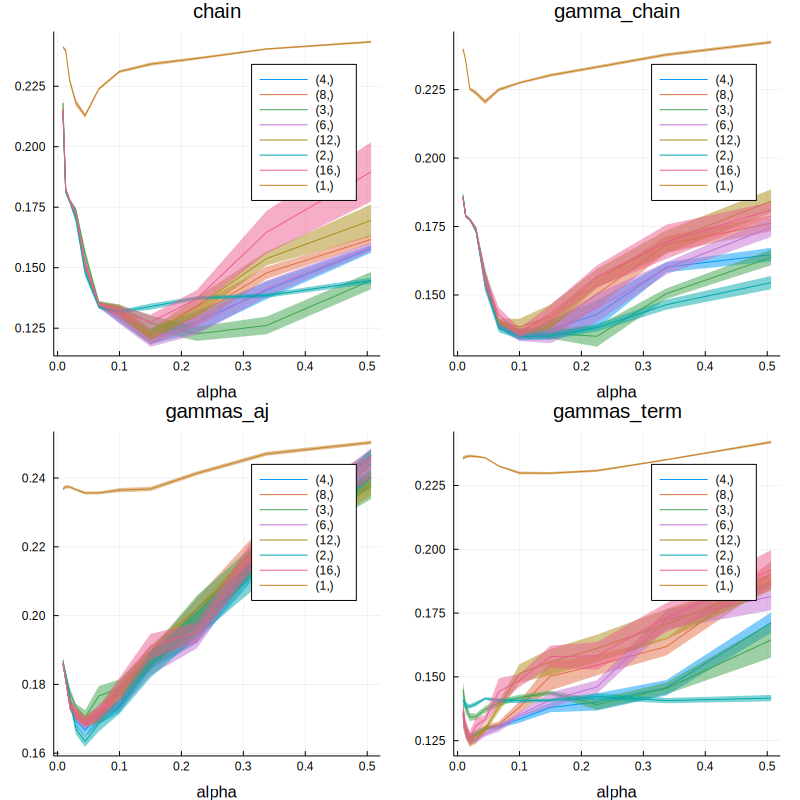

In [51]:
plot_gvfn_stepsize_sense(ic_gvfn, 10, "gammas_term", "end")

# RMSProp

In [61]:
ic_gvfn_rmsprop = ItemCollection(joinpath(data_home, "ringworld_gvfn_rmsprop/data"))
diff(ic_gvfn_rmsprop)

Dict{String,Array} with 6 entries:
  "alpha"      => [0.000260123, 0.000390184, 0.000585277, 0.000877915, 0.001316…
  "truncation" => [1, 2, 3, 4, 6, 8, 12, 16]
  "outhorde"   => ["gammas_term", "onestep"]
  "horde"      => ["chain", "gamma_chain", "gammas_aj", "gammas_term"]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "size"       => [6, 10]

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


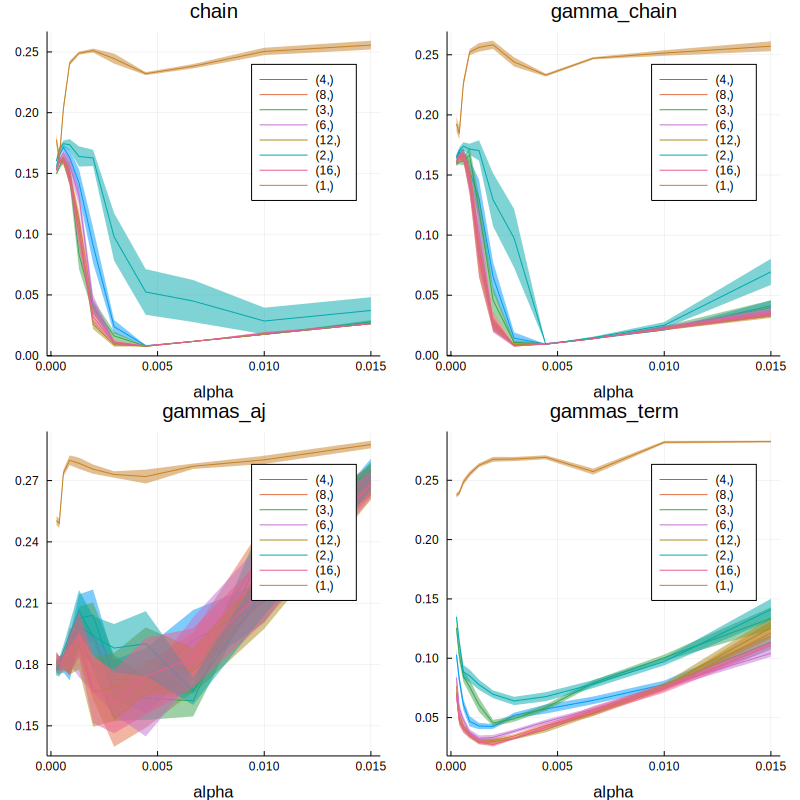

In [62]:
plot_gvfn_stepsize_sense(ic_gvfn_rmsprop, 6, "onestep", "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


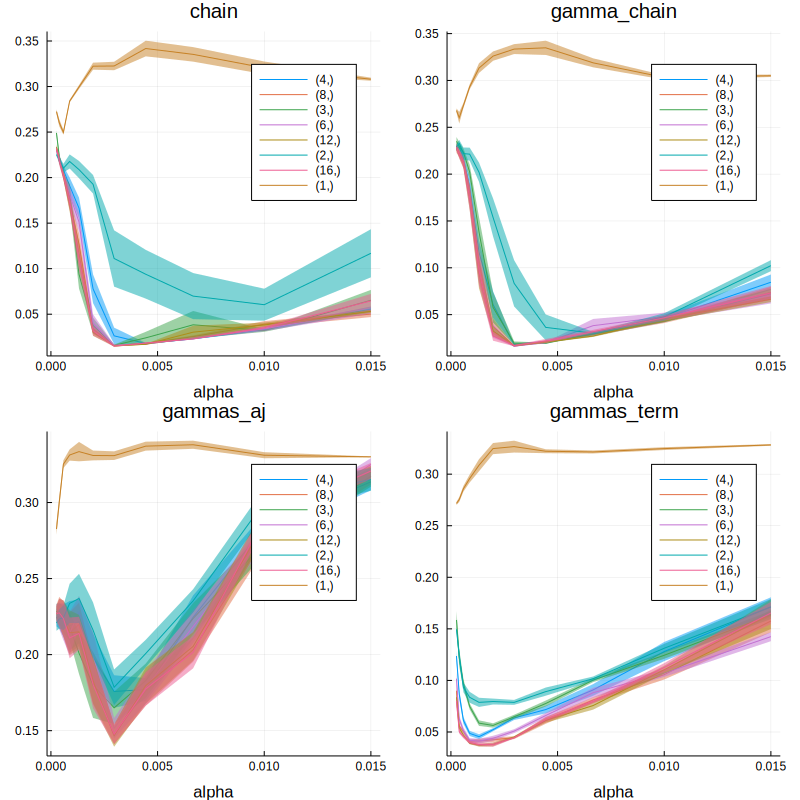

In [63]:
plot_gvfn_stepsize_sense(ic_gvfn_rmsprop, 6, "gammas_term", "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


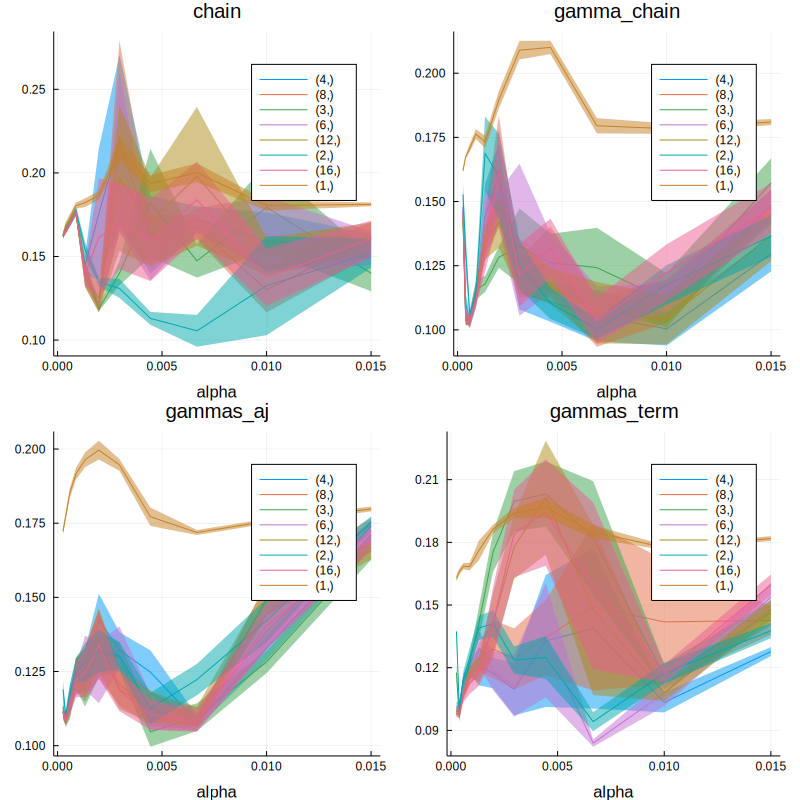

In [64]:
plot_gvfn_stepsize_sense(ic_gvfn_rmsprop, 10, "onestep", "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


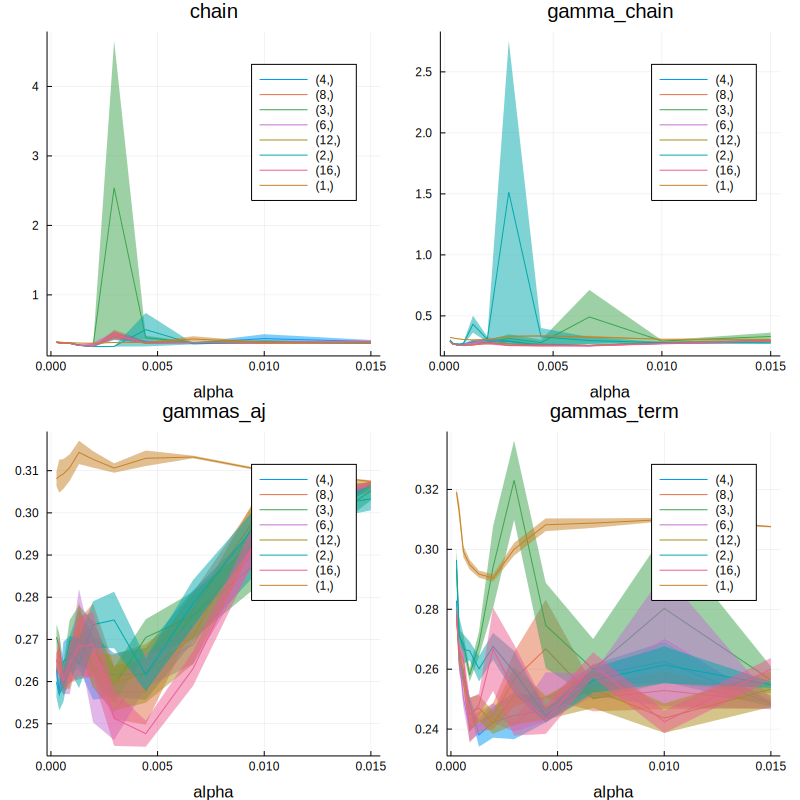

In [65]:
plot_gvfn_stepsize_sense(ic_gvfn_rmsprop, 10, "gammas_term", "end")

## Adam

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


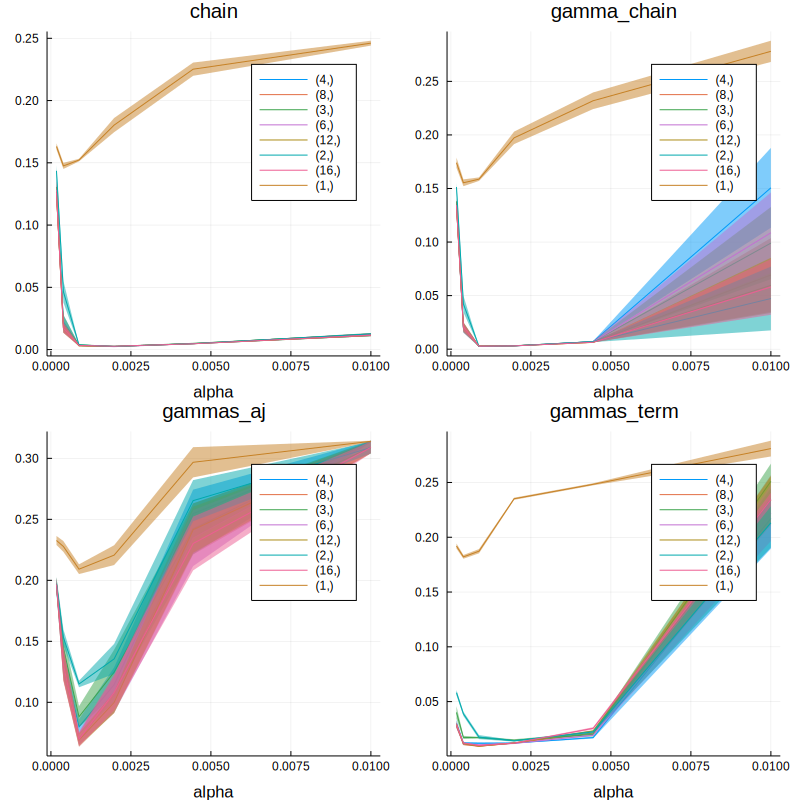

In [66]:
plot_gvfn_stepsize_sense(ic_gvfn_adam, 6, "onestep", "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


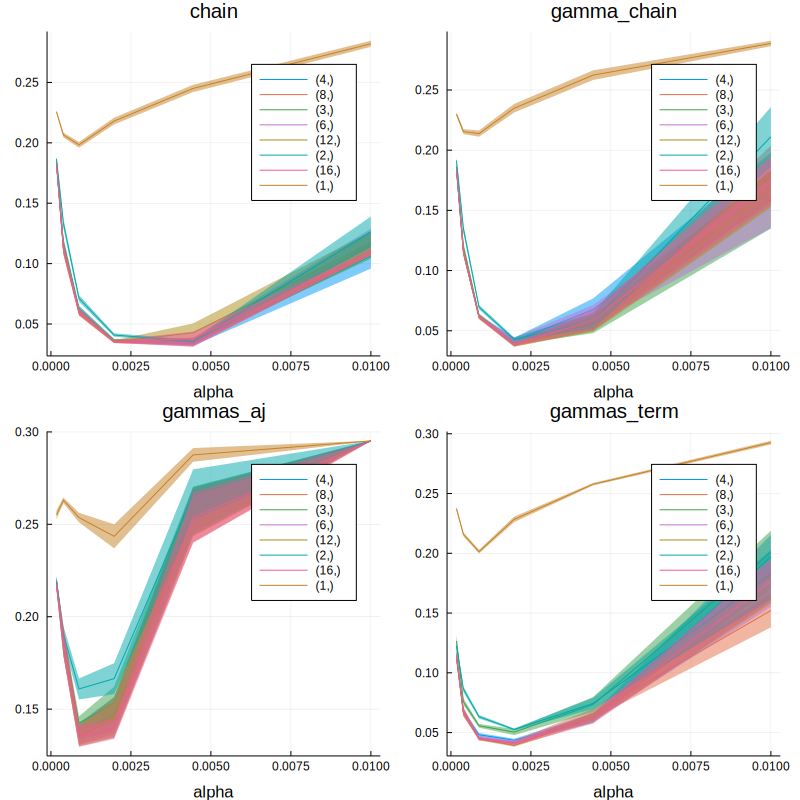

In [38]:
plot_gvfn_stepsize_sense(ic_gvfn_adam, 6, "gammas_term", "all")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


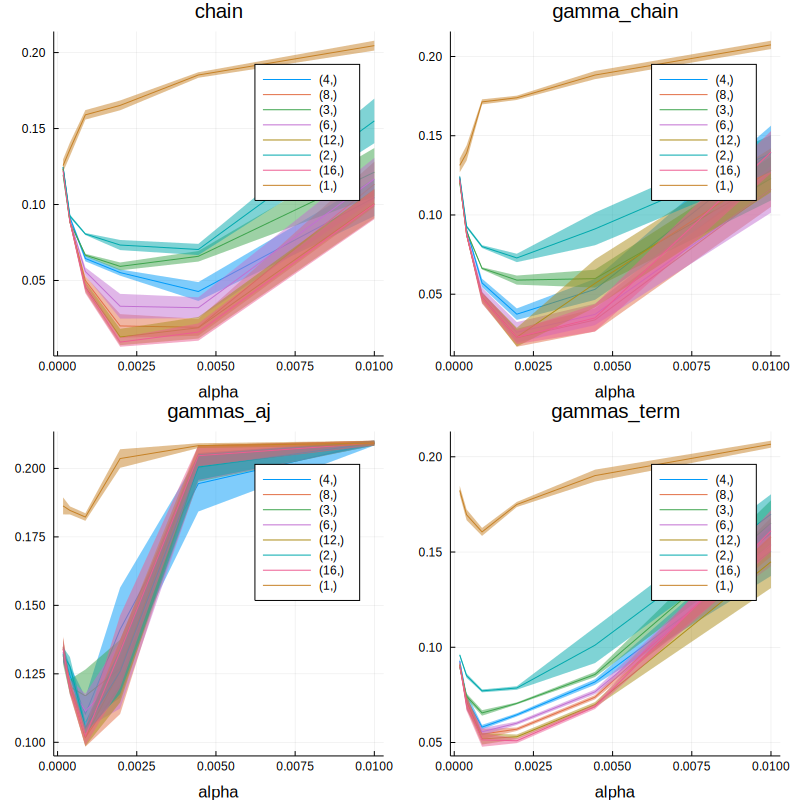

In [68]:
plot_gvfn_stepsize_sense(ic_gvfn_adam, 10, "onestep", "end")

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


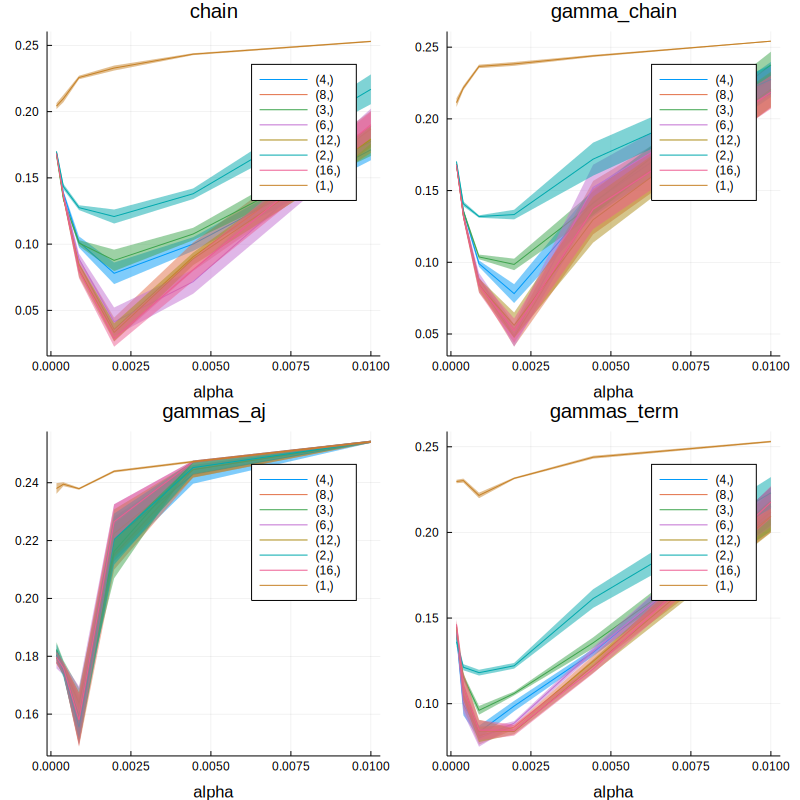

In [69]:
plot_gvfn_stepsize_sense(ic_gvfn_adam, 10, "gammas_term", "end")

# RNN

In [88]:
ic_rnn = ItemCollection(joinpath(data_home, "ringworld_rnn/data"));
diff(ic_rnn)

Dict{String,Array} with 7 entries:
  "hidden"     => [14, 22]
  "alpha"      => [0.00877915, 0.0131687, 0.0197531, 0.0296296, 0.0444444, 0.06…
  "truncation" => [1, 2, 3, 4, 6, 8, 12, 16]
  "outhorde"   => ["gammas_term", "onestep"]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "size"       => [6, 10]
  "cell"       => ["ARNN", "GRU", "LSTM"]

In [99]:
rnn_final_params = get_final_rnn_params(ic_rnn, 6, "onestep", "end")
println(rnn_final_params)

0.13573321776885502
0.0038666551105065484
0.0020511097029121306
0.0017890476169702273
0.0014472988107988457
0.0013650686889314335
0.0013541530027872993
0.0012681648006001235
0.11858883632331943
0.020116392676460877
0.01245715922877837
0.00855717025477459
0.005696779941181232
0.005402266383293568
0.004534414146396415
0.0046433358069436995
0.11253656086237669
0.019825272123875512
0.011162978285683349
0.008129265141155743
0.005623358882154387
0.005488643353948041
0.005805653102571725
0.0056937606809998684
Any[Dict{String,Any}("alpha" => 0.02962962962962963,"truncation" => 1,"cell" => "ARNN"), Dict{String,Any}("alpha" => 0.225,"truncation" => 2,"cell" => "ARNN"), Dict{String,Any}("alpha" => 0.225,"truncation" => 3,"cell" => "ARNN"), Dict{String,Any}("alpha" => 0.225,"truncation" => 4,"cell" => "ARNN"), Dict{String,Any}("alpha" => 0.225,"truncation" => 6,"cell" => "ARNN"), Dict{String,Any}("alpha" => 0.225,"truncation" => 8,"cell" => "ARNN"), Dict{String,Any}("alpha" => 0.225,"truncation" =

In [90]:
rnn_final_params["cell"]

Dict{Int64,Any} with 8 entries:
  12 => 0.50625
  4  => 0.3375
  2  => 0.225
  3  => 0.225
  16 => 0.3375
  8  => 0.50625
  6  => 0.3375
  1  => 0.3375

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


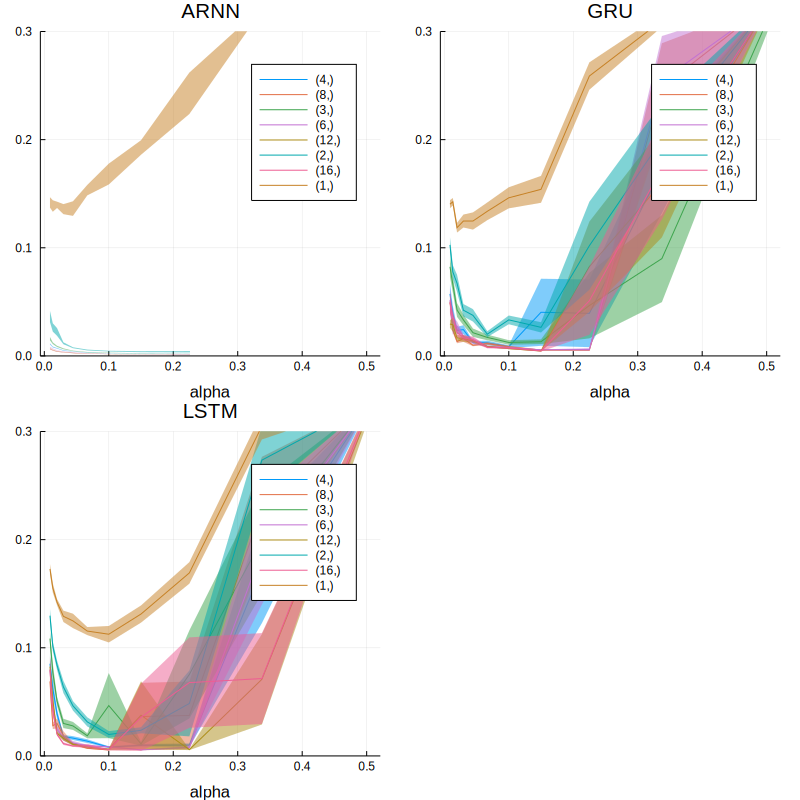

In [95]:
plot_rnn_stepsize_sens(ic_rnn, 6, "onestep", "end", ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:02
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02
Line: 100%|█████████████████████████████████████████████| Time: 0:00:02


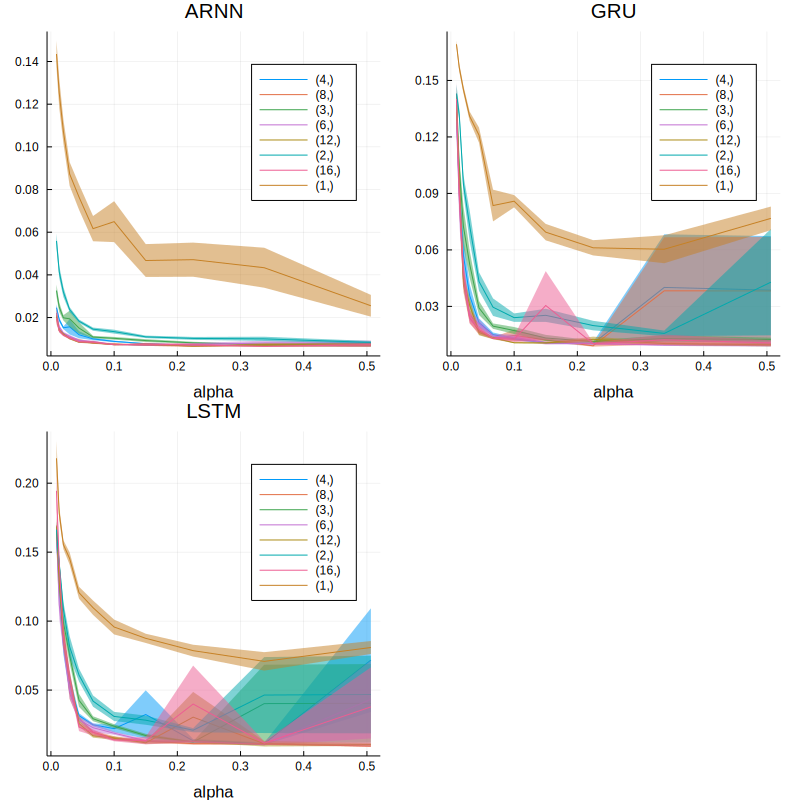

In [73]:
plot_rnn_stepsize_sens(ic_rnn, 6, "gammas_term", "end", ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


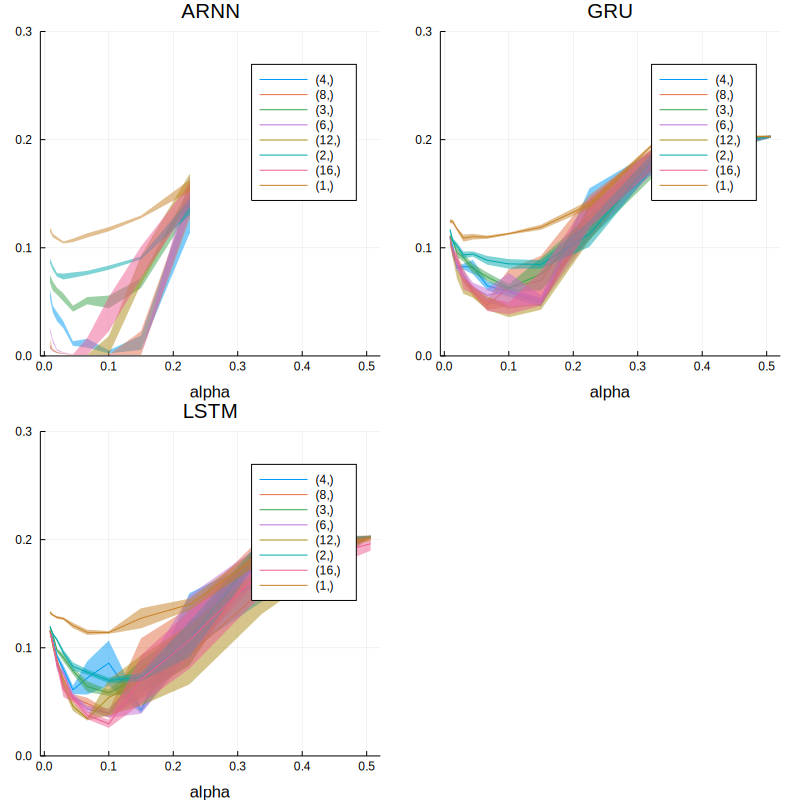

In [81]:
plot_rnn_stepsize_sens(ic_rnn, 10, "onestep", "end", ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


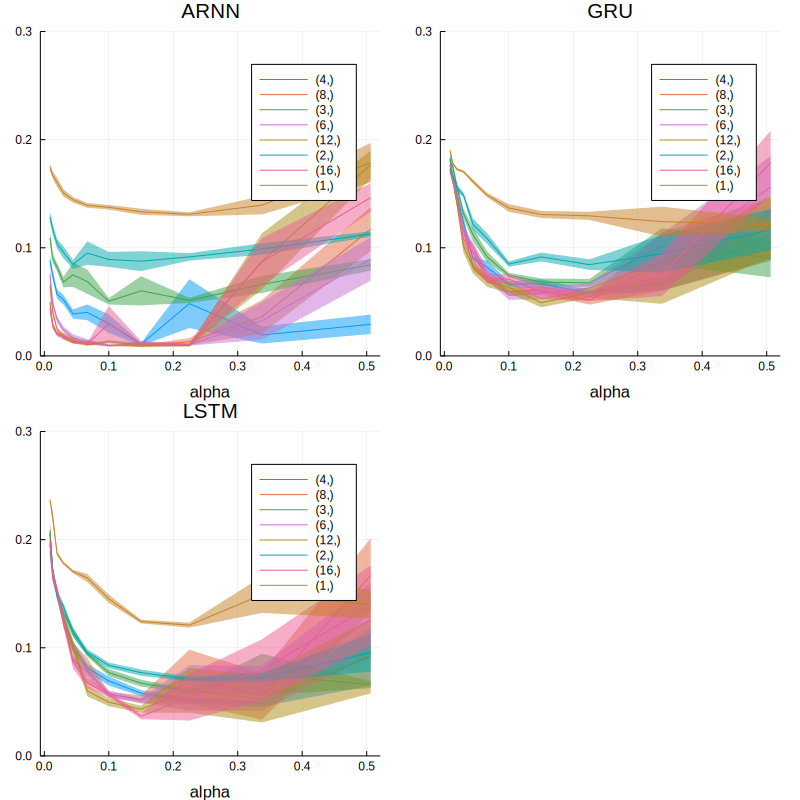

In [82]:
plot_rnn_stepsize_sens(ic_rnn, 10, "gammas_term", "end", ylims=(0.0,0.3))

## RMSProp

In [83]:
ic_rnn_rmsprop = ItemCollection(joinpath(data_home, "ringworld_rnn_rmsprop/data"));
diff(ic_rnn_rmsprop)

Dict{String,Array} with 7 entries:
  "hidden"     => [14, 22]
  "alpha"      => [0.000260123, 0.000390184, 0.000585277, 0.000877915, 0.001316…
  "truncation" => [1, 2, 3, 4, 6, 8, 12, 16]
  "outhorde"   => ["gammas_term", "onestep"]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "size"       => [6, 10]
  "cell"       => ["ARNN", "GRU", "LSTM"]

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


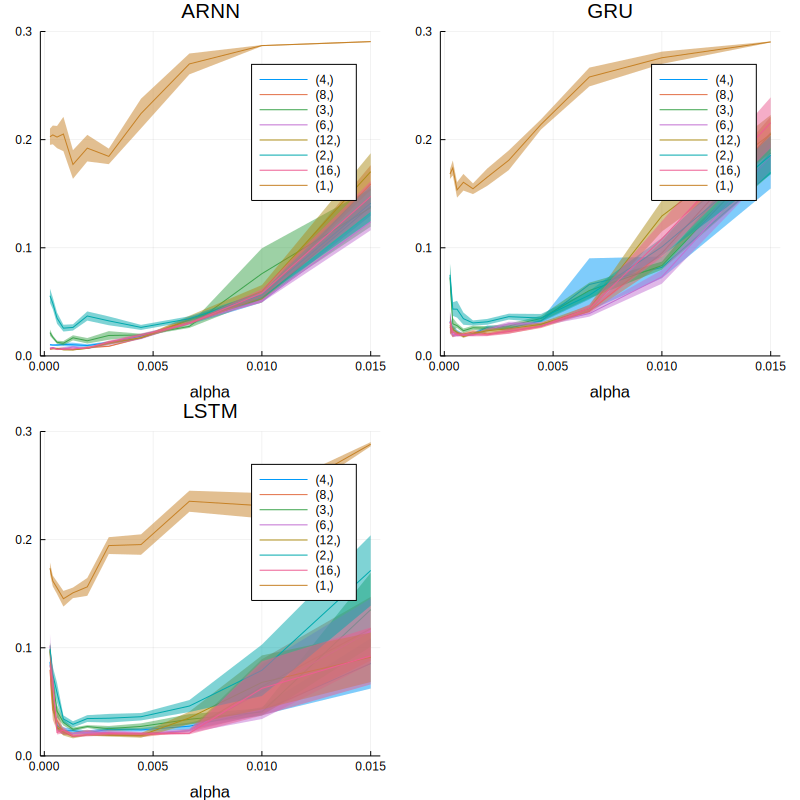

In [84]:
plot_rnn_stepsize_sens(ic_rnn_rmsprop, 6, "onestep", "end", ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


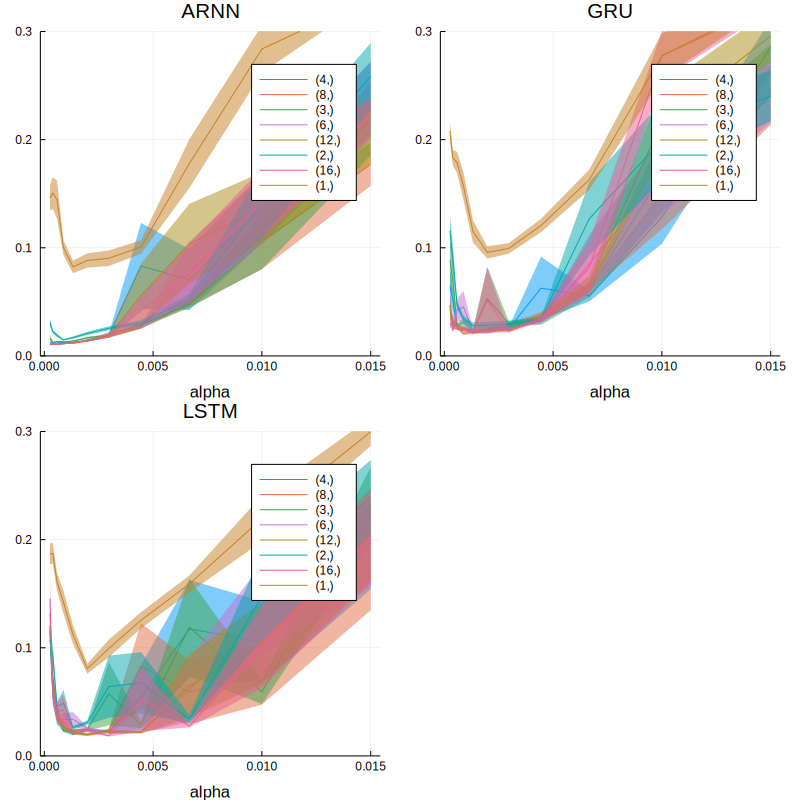

In [85]:
plot_rnn_stepsize_sens(ic_rnn_rmsprop, 6, "gammas_term", "end", ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


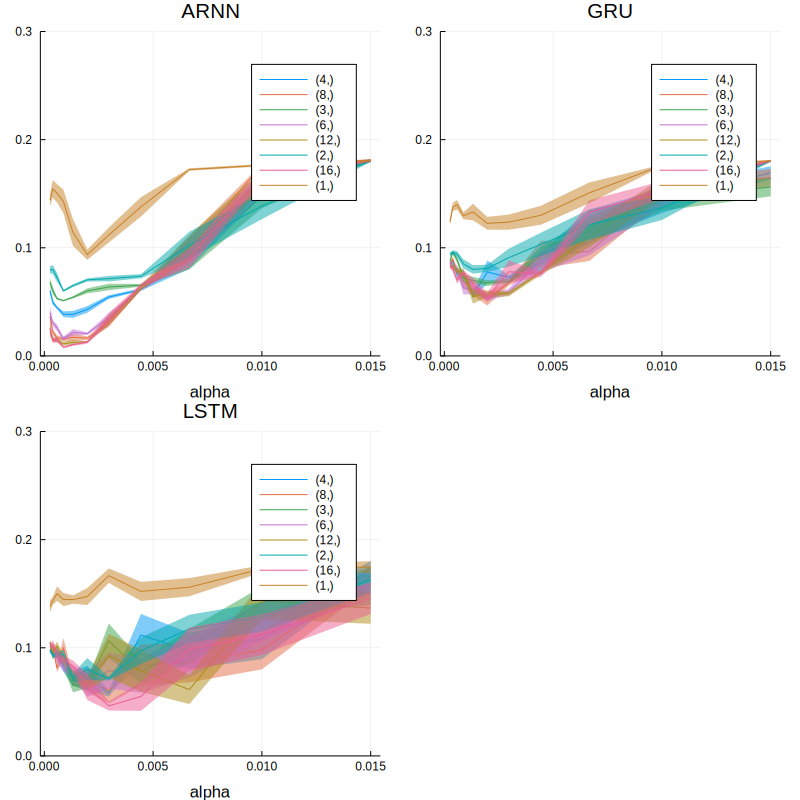

In [86]:
plot_rnn_stepsize_sens(ic_rnn_rmsprop, 10, "onestep", "end", ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:00


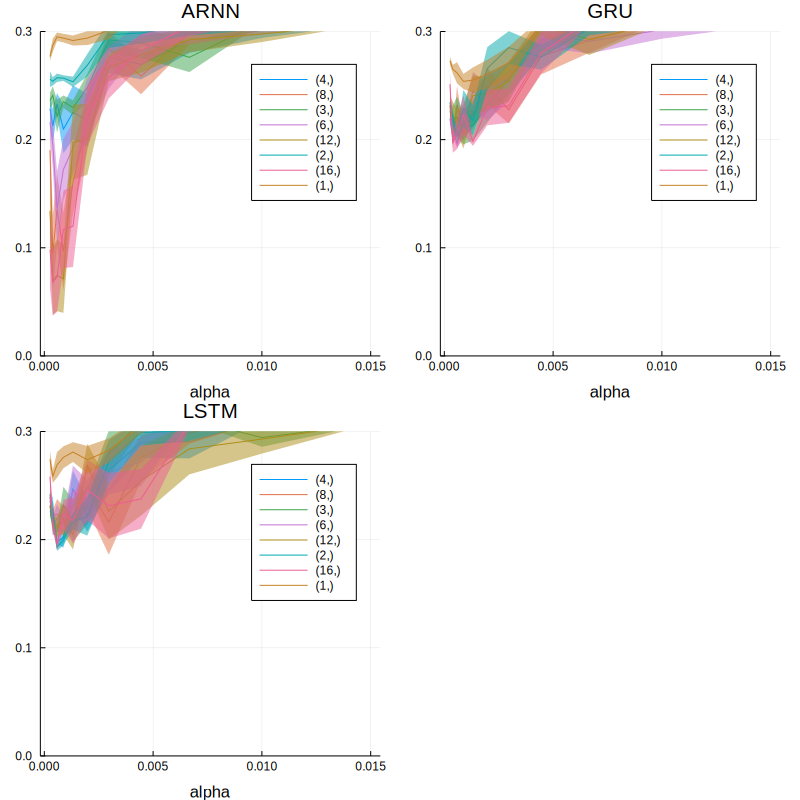

In [87]:
plot_rnn_stepsize_sens(ic_rnn_rmsprop, 10, "gammas_term", "end", ylims=(0.0,0.3))

## Adam

In [88]:
ic_rnn_adam = ItemCollection(joinpath(data_home, "ringworld_rnn_adam/data"));
diff(ic_rnn_adam)

Dict{String,Array} with 7 entries:
  "hidden"     => [14, 22]
  "alpha"      => [0.000173415, 0.000390184, 0.000877915, 0.00197531, 0.0044444…
  "truncation" => [1, 2, 3, 4, 6, 8, 12, 16]
  "outhorde"   => ["gammas_term", "onestep"]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "size"       => [6, 10]
  "cell"       => ["ARNN", "GRU", "LSTM"]

Line: 100%|█████████████████████████████████████████████| Time: 0:00:00
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


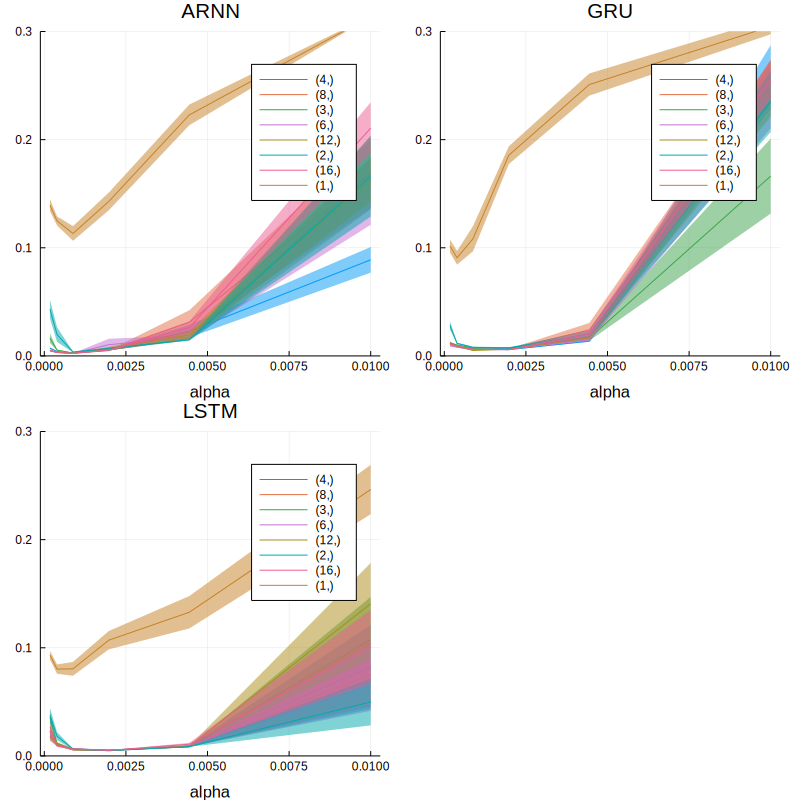

In [89]:
plot_rnn_stepsize_sens(ic_rnn_adam, 6, "onestep", "end", ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


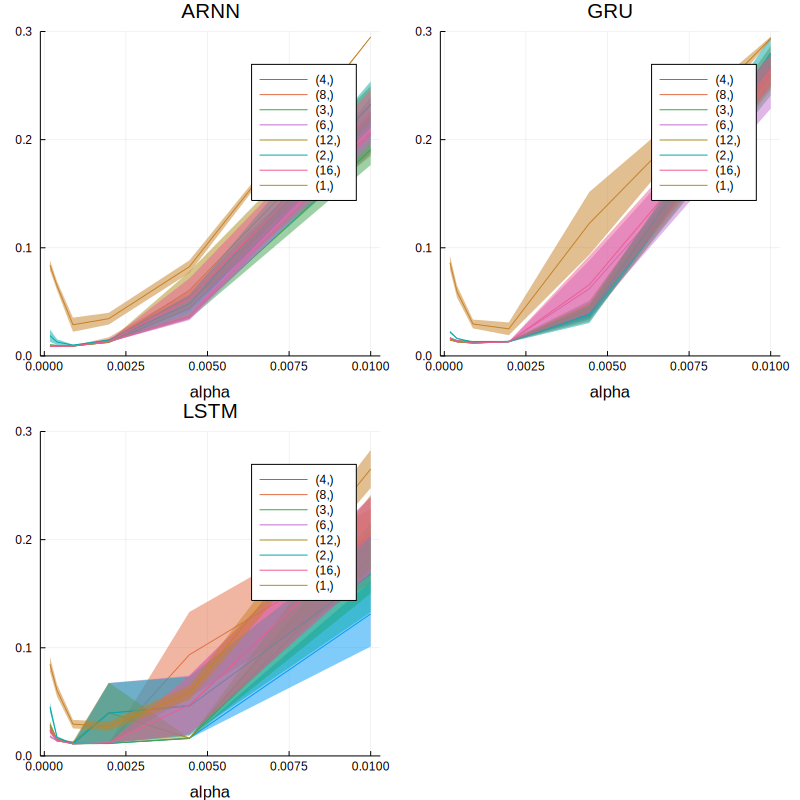

In [90]:
plot_rnn_stepsize_sens(ic_rnn_adam, 6, "gammas_term", "end", ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


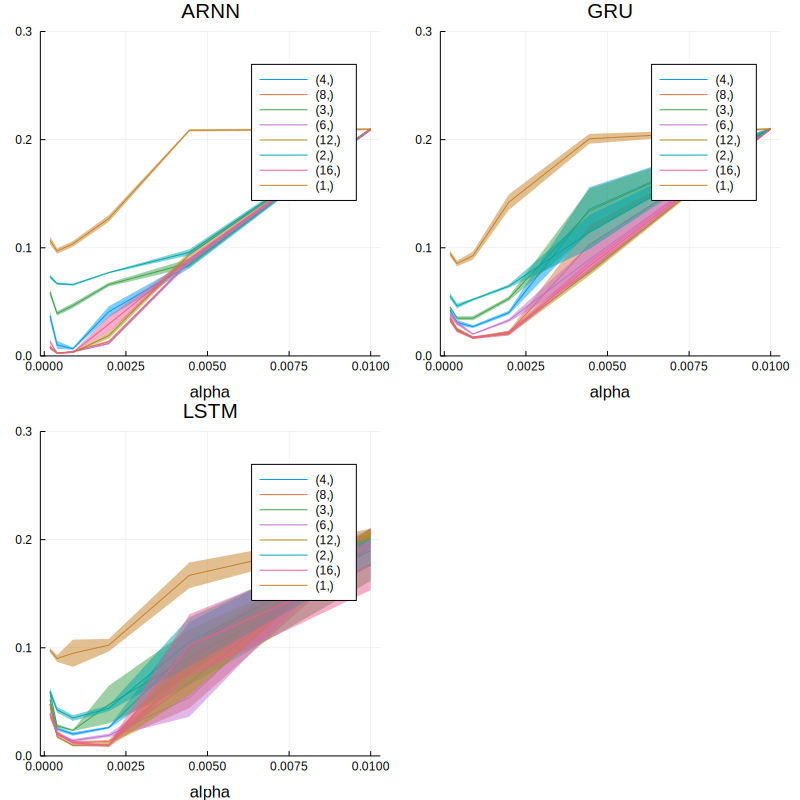

In [91]:
plot_rnn_stepsize_sens(ic_rnn_adam, 10, "onestep", "end", ylims=(0.0,0.3))

Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01
Line: 100%|█████████████████████████████████████████████| Time: 0:00:01


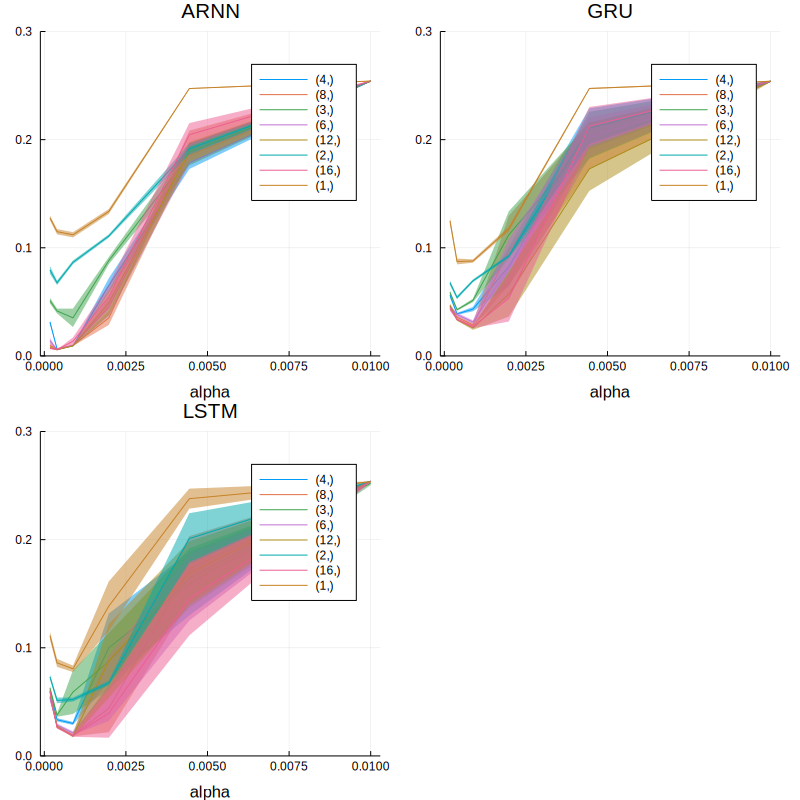

In [92]:
plot_rnn_stepsize_sens(ic_rnn_adam, 10, "gammas_term", "end", ylims=(0.0,0.3))

# Final Parameters

In [30]:
function get_final_gvfn_params(ic, s, outhorde, res_key)
#     clean_func=(d)->d["results"][res_key]
    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    
    sub_ic = search(ic, Dict("size"=>s, "outhorde"=>outhorde))
#     params = Dict{String, Any}()
    arg_list = Dict{String, Any}[]
    @showprogress for horde ∈ diff(sub_ic)["horde"]
        sub_sub_ic = search(sub_ic, Dict("horde"=>horde))
#         arg_list = Dict{String, Any}[]
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, _ = get_best_func(sub_sub_sub_ic)
            push!(arg_list, Dict("horde"=>horde, "truncation"=>τ, "alpha"=>prm))
        end
#         params[horde] = arg_list
    end
    arg_list
end

function get_final_rnn_params(ic, s, outhorde, res_key)
#     clean_func=(d)->d["results"][res_key]
    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    
    sub_ic = search(ic, Dict("size"=>s, "outhorde"=>outhorde))
#     params = Dict{String, Any}()
    arg_list = []
    for cell ∈ diff(sub_ic)["cell"]
        sub_sub_ic = search(sub_ic, Dict("cell"=>cell))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, (μ, σ) = get_best_func(sub_sub_sub_ic)
#             println(μ)
            push!(arg_list, Dict("cell"=>cell, "truncation"=>τ, "alpha"=>prm)) #itm.parsed_args
        end
    end
    arg_list
end

get_final_rnn_params (generic function with 1 method)

## GVFNs

In [72]:
ic_gvfn = ItemCollection(joinpath(data_home, "ringworld_gvfn/data"));
ic_gvfn_rmsprop = ItemCollection(joinpath(data_home, "ringworld_gvfn_rmsprop/data"));
ic_gvfn_adam = ItemCollection(joinpath(data_home, "ringworld_gvfn_adam/data"));
diff(ic_gvfn)

Dict{String,Array} with 6 entries:
  "alpha"      => [0.00877915, 0.0131687, 0.0197531, 0.0296296, 0.0444444, 0.06…
  "horde"      => ["chain", "gamma_chain", "gammas_aj", "gammas_aj_term", "gamm…
  "outhorde"   => ["gammas_term", "onestep"]
  "truncation" => [1, 2, 3, 4, 6, 8, 12, 16]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "size"       => [6, 10]

In [13]:
ic_gvfn.items

14080-element Array{Reproduce.Item,1}:
 Reproduce.Item("../working_results/sweeps/ringworld_gvfn/data/RP_0_0x101bda7d5fe0e616", Dict{String,Any}("opt" => "Descent","steps" => 300000,"outhorde" => "onestep","outgamma" => 0.0,"_GIT_INFO" => "0","activation" => "sigmoid","sweep" => true,"alpha" => 0.008779149519890261,"horde" => "chain","size" => 10…), ["opt", "steps", "outhorde", "outgamma", "activation", "sweep", "alpha", "horde", "size", "truncation", "gamma", "seed"])         
 Reproduce.Item("../working_results/sweeps/ringworld_gvfn/data/RP_0_0x10204c2265992dd9", Dict{String,Any}("opt" => "Descent","steps" => 300000,"outhorde" => "onestep","outgamma" => 0.0,"_GIT_INFO" => "0","activation" => "sigmoid","sweep" => true,"alpha" => 0.008779149519890261,"horde" => "gammas_term","size" => 6…), ["opt", "steps", "outhorde", "outgamma", "activation", "sweep", "alpha", "horde", "size", "truncation", "gamma", "seed"])    
 Reproduce.Item("../working_results/sweeps/ringworld_gvfn/data/RP_0_0x102

In [73]:
d = diff(ic_gvfn)
args_list = Dict{String, Any}[]
for (s, oh) in Iterators.product(d["size"], d["outhorde"])
    add_size_and_oh = (dict)->begin; dict["size"] = s; dict["outhorde"]=oh; dict; end;
    append!(args_list, add_size_and_oh.(get_final_gvfn_params(ic_gvfn, s, oh, "end")))
end

@save "../final_run_params/ringworld/ringworld_gvfn_descent.jld2" args_list

# println(args_list)
# get_final_gvfn_params(ic_gvfn, 6, "onestep", "end")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


In [74]:
d = diff(ic_gvfn_rmsprop)
args_list = Dict{String, Any}[]
for (s, oh) in Iterators.product(d["size"], d["outhorde"])
    add_size_and_oh = (dict)->begin; dict["size"] = s; dict["outhorde"]=oh; dict; end;
    append!(args_list, add_size_and_oh.(get_final_gvfn_params(ic_gvfn_rmsprop, s, oh, "end")))
end

@save "../final_run_params/ringworld/ringworld_gvfn_rmsprop.jld2" args_list

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


In [75]:
d = diff(ic_gvfn_adam)
args_list = Dict{String, Any}[]
for (s, oh) in Iterators.product(d["size"], d["outhorde"])
    add_size_and_oh = (dict)->begin; dict["size"] = s; dict["outhorde"]=oh; dict; end;
    append!(args_list, add_size_and_oh.(get_final_gvfn_params(ic_gvfn_adam, s, oh, "end")))
end

@save "../final_run_params/ringworld/ringworld_gvfn_adam.jld2" args_list

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


## RNN

In [76]:
ic_rnn = ItemCollection(joinpath(data_home, "ringworld_rnn/data"));
ic_rnn_rmsprop = ItemCollection(joinpath(data_home, "ringworld_rnn_rmsprop/data"));
ic_rnn_adam = ItemCollection(joinpath(data_home, "ringworld_rnn_adam/data"));
# diff(ic_rnn)

In [77]:
d = diff(ic_rnn)
args_list = Dict{String, Any}[]
for (s, oh) in Iterators.product(d["size"], d["outhorde"])
    add_size_and_oh = (dict)->begin; dict["size"] = s; dict["outhorde"]=oh; dict; end;
    append!(args_list, add_size_and_oh.(get_final_rnn_params(ic_rnn, s, oh, "end")))
end

@save "../final_run_params/ringworld/ringworld_rnn.jld2" args_list

In [78]:
d = diff(ic_rnn_rmsprop)
args_list = Dict{String, Any}[]
for (s, oh) in Iterators.product(d["size"], d["outhorde"])
    add_size_and_oh = (dict)->begin; dict["size"] = s; dict["outhorde"]=oh; dict; end;
    append!(args_list, add_size_and_oh.(get_final_rnn_params(ic_rnn_rmsprop, s, oh, "end")))
end

@save "../final_run_params/ringworld/ringworld_rnn_rmsprop.jld2" args_list

In [79]:
d = diff(ic_rnn_adam)
args_list = Dict{String, Any}[]
for (s, oh) in Iterators.product(d["size"], d["outhorde"])
    add_size_and_oh = (dict)->begin; dict["size"] = s; dict["outhorde"]=oh; dict; end;
    append!(args_list, add_size_and_oh.(get_final_rnn_params(ic_rnn_adam, s, oh, "end")))
end

@save "../final_run_params/ringworld/ringworld_rnn_adam.jld2" args_list

# Forecast

In [80]:
ic_forecast = ItemCollection(joinpath(data_home, "ringworld_forecast/data"));
ic_forecast_rmsprop = ItemCollection(joinpath(data_home, "ringworld_forecast_rmsprop/data"));
ic_forecast_adam = ItemCollection(joinpath(data_home, "ringworld_forecast_adam/data"));
# diff(ic_rnn)

In [84]:
diff(ic_forecast)

Dict{String,Array} with 8 entries:
  "hidden"     => [14, 22]
  "alpha"      => [0.00877915, 0.0131687, 0.0197531, 0.0296296, 0.0444444, 0.06…
  "truncation" => [1, 2, 3, 4, 6, 8, 12, 16]
  "outhorde"   => ["gammas_term", "onestep"]
  "klength"    => [14, 22]
  "seed"       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  "size"       => [6, 10]
  "cell"       => ["ARNNCell", "GRUCell", "LSTMCell"]

In [81]:
# diff(search(ic_forecast, Dict("size"=>6, "klength"=>22)))
d = diff(ic_forecast)
klength_dict = Dict(6=>14, 10=>22)
args_list = Dict{String, Any}[]
for (s, oh) in Iterators.product(d["size"], d["outhorde"])
    add_size_and_oh = (dict)->begin; dict["size"] = s; dict["outhorde"]=oh; dict["klength"]=klength_dict[s]; dict; end;
    sub_ic_forecast = search(ic_forecast, Dict("klength"=>klength_dict[s]))
    append!(args_list, add_size_and_oh.(get_final_rnn_params(sub_ic_forecast, s, oh, "end")))
end

@save "../final_run_params/ringworld/ringworld_forecast.jld2" args_list

In [82]:
# diff(search(ic_forecast, Dict("size"=>6, "klength"=>22)))
d = diff(ic_forecast_rmsprop)
klength_dict = Dict(6=>14, 10=>22)
args_list = Dict{String, Any}[]
for (s, oh) in Iterators.product(d["size"], d["outhorde"])
    add_size_and_oh = (dict)->begin; dict["size"] = s; dict["outhorde"]=oh; dict["klength"]=klength_dict[s]; dict; end;
    sub_ic_forecast = search(ic_forecast_rmsprop, Dict("klength"=>klength_dict[s]))
    append!(args_list, add_size_and_oh.(get_final_rnn_params(sub_ic_forecast, s, oh, "end")))
end

@save "../final_run_params/ringworld/ringworld_forecast_rmsprop.jld2" args_list

In [83]:
# diff(search(ic_forecast, Dict("size"=>6, "klength"=>22)))
d = diff(ic_forecast_adam)
klength_dict = Dict(6=>14, 10=>22)
args_list = Dict{String, Any}[]
for (s, oh) in Iterators.product(d["size"], d["outhorde"])
    add_size_and_oh = (dict)->begin; dict["size"] = s; dict["outhorde"]=oh; dict["klength"]=klength_dict[s]; dict; end;
    sub_ic_forecast = search(ic_forecast_adam, Dict("klength"=>klength_dict[s]))
    append!(args_list, add_size_and_oh.(get_final_rnn_params(sub_ic_forecast, s, oh, "end")))
end

@save "../final_run_params/ringworld/ringworld_forecast_adam.jld2" args_list